In [1]:
import copy
import os
import time

from apppath import ensure_existence
from draugr.numpy_utilities import SplitEnum
from draugr.torch_utilities import (
    TensorBoardPytorchWriter,
    TorchEvalSession,
    global_torch_device,
    to_device_iterator,
)
from draugr.visualisation import plot_img_array, plot_side_by_side
from draugr.writers import Writer
from itertools import cycle
from matplotlib import pyplot
from pathlib import Path
from torch.nn.modules.module import Module
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torchvision import transforms
from typing import Iterator
import torch
from torch import optim
from tqdm import tqdm
from torchvision.datasets import MNIST

from neodroidvision import PROJECT_APP_PATH
from neodroidvision.multitask import SkipHourglassFission
from neodroidvision.utilities.torch_utilities.layers.torch_layers import MinMaxNorm

loading previous model: /home/heider/.local/share/neodroidvision/unet_mnist/INTERRUPTED_BEST.model


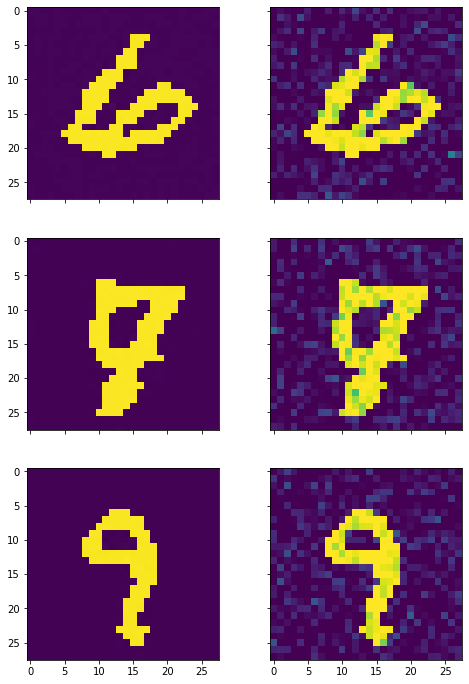

In [2]:
def inference(
    model: Module, data_iterator: Iterator, denoise: bool = True, num: int = 3
) -> None:
    """

    :param model:
    :type model:
    :param data_iterator:
    :type data_iterator:"""
    with torch.no_grad():
        with TorchEvalSession(model):
            img, target = next(data_iterator)
            if denoise:
                model_input = img + torch.normal(
                    mean=0.0, std=0.1, size=img.shape, device=global_torch_device()
                )
            else:
                model_input = img
            model_input = torch.clamp(model_input, 0.0, 1.0)
            pred, *_ = model(model_input)
            plot_side_by_side(
                [
                    pred.squeeze(1)[:num].cpu().numpy(),
                    model_input.squeeze(1)[:num].cpu().numpy(),
                ]
            )
            pyplot.show()
            return


def run_mnist(denoise: bool = True):
    """

    :param load_earlier:
    :type load_earlier:
    :param train:
    :type train:"""
    seed = 251645
    batch_size = 32

    tqdm.monitor_interval = 0
    unet_depth = 3
    unet_start_channels = 16
    input_channels = 1
    output_channels = (input_channels,)

    home_path = PROJECT_APP_PATH
    model_file_ending = ".model"
    model_base_path = ensure_existence(PROJECT_APP_PATH.user_data / "unet_mnist")
    interrupted_name = "INTERRUPTED_BEST"
    interrupted_path = model_base_path / f"{interrupted_name}{model_file_ending}"

    torch.manual_seed(seed)

    device = global_torch_device()

    img_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            MinMaxNorm(),
            transforms.Lambda(lambda tensor: torch.round(tensor)),
        ]
    )
    dataset = MNIST(
        PROJECT_APP_PATH.user_data / "mnist", transform=img_transform, download=True
    )
    data_iter = iter(
        cycle(DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True))
    )
    data_iter = to_device_iterator(data_iter, device)

    model = SkipHourglassFission(
        input_channels=input_channels,
        output_heads=output_channels,
        encoding_depth=unet_depth,
        start_channels=unet_start_channels,
    ).to(global_torch_device())

    _list_of_files = list(
        model_base_path.rglob(f"{interrupted_name}{model_file_ending}")
    )
    if not len(_list_of_files):
        print(
            f"found no trained models under {model_base_path}{os.path.sep}**{os.path.sep}{interrupted_name}{model_file_ending}"
        )
        exit(1)
    latest_model_path = str(max(_list_of_files, key=os.path.getctime))
    print(f"loading previous model: {latest_model_path}")
    if latest_model_path is not None:
        model.load_state_dict(torch.load(latest_model_path))

    inference(model, data_iter, denoise=denoise)

    torch.cuda.empty_cache()


if __name__ == "__main__":
    run_mnist()

Left is the denoised prediction and right is the noisy input